# Time Series Model Deploy

2022 June 15

## What should a deployed model do?

1. Training. Trin or tune model based on example data set and business requirements
1. Predict. Compute expected model ouputs based on novel input data (We refer to these as _predictions_ because they are potentially novel and their quality is provisional.)
1. Data Validation. Verify validity of input data
1. Model Performance. Provide metrics of model performance
1. Provenance. Keep track of provencence in a string of computations, over time and over model execution
1. Orchastration. Cooperate with other elements in the data pipeline
1. Encapsulation. Encapsulate model functionality and optimized parameters in ways support iteration

## Simple Example

Deploy our a Time Series model to K8S as scaleable service with a Restful interface.

### Training
For a real time model, we want to keep the model up to date with the latest behavior. So, we need to train the model every after every period goes by in order to include new data.

### Predict
Batch prediction of earnings level on 1 or more rows of valid input historical time series data.

### Data Validation
Use the training data to set statistical warnings we input data is out of bounds.  Additionally, would be useful to know when the distribution of the data is drifting. We probably want bounds on how large and how small the data set can be. (Not implemented here.)

### Model Performance 
As model is retrained, want to update evaluations of performance. This implementation uses the cross-validation technique illustrated 2 weeks ago.

### Provenance
Model versioning. Minimal logging. In this case, we probably want every train and every predict to log a model_id, a client_id and basic information about the data in the requests.

### Orchestration
K8s Servcie with 2 pods, K8s Ingress with NGINX loadbalancing. Shared model persistence.

### Encapsulation
Project in Github and deployed Docker image include data, validation data, model code and pickled model (parameters) by verion and build number.

In [1]:
import pandas as pd

from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
!ls ../data
df = pd.read_csv('../data/example_wp_log_peyton_manning.csv')
df.head()

example_wp_log_peyton_manning.csv


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7975.31    0.00415855       247.015      0.7831      0.7831      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7994.53      0.010249        344.02           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       7995.33   5.91718e-05       165.006   4.517e-07       0.001      316  LS failed, Hessian reset 
     299       7997.26   0.000813407       209.659       6.754      0.6754      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        8001.1   0.000792021       147.659      0.5991           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     488       8002.21   7.22552e-05    

In [4]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [5]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.206428,7.508240,8.965197
3266,2017-01-16,8.531431,7.782896,9.217103
3267,2017-01-17,8.318846,7.562432,9.045449
3268,2017-01-18,8.151448,7.425613,8.905806
3269,2017-01-19,8.163386,7.434825,8.931775


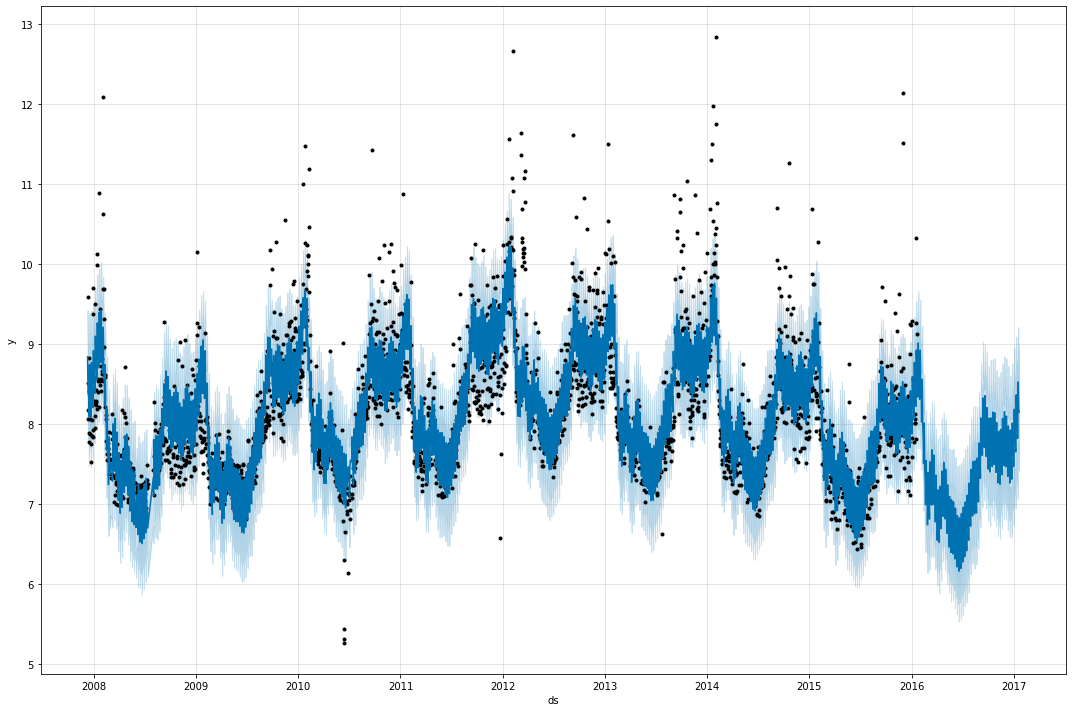

In [6]:
fig1 = m.plot(forecast, figsize=[15,10])

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


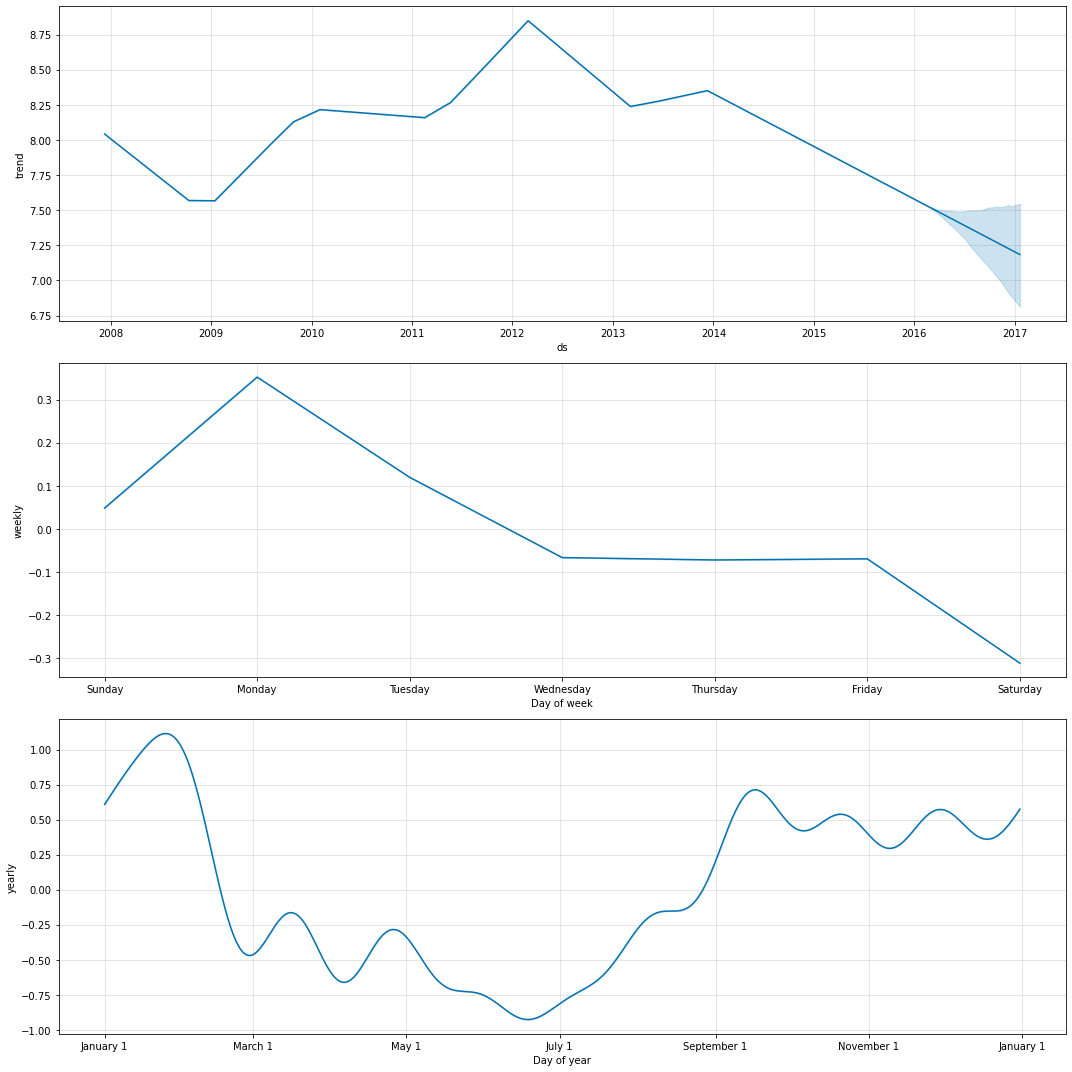

In [7]:
fig2 = m.plot_components(forecast, figsize=[15,15])

In [8]:
df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days')

INFO:prophet:Making 6 forecasts with cutoffs between 2010-01-21 00:00:00 and 2015-01-20 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.24359
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2181.64    0.00248117       81.3273      0.3526           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       2181.97   8.75754e-05       112.379   1.038e-06       0.001      267  LS failed, Hessian reset 
     199          2182   2.16008e-06        75.108     0.07564           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236          2182   4.70967e-08       72.1606      0.1971      0.1971      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.22773
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3100.08     0.0010058       97.5334      0.5992     0.05992      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       3103.99   6.17275e-05       80.4644   4.204e-07       0.001      260  LS failed, Hessian reset 
     199       3104.24   6.06317e-05       63.1583      0.2831      0.2831      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3105.37   0.000365253       78.1194      0.2966           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       3105.54   0.000298228       210.431   4.492e-06       0.001      492  LS failed, Hessian reset 
     380       3105.73   0.000180604       95.5211   2.446e-06       0.001      578  LS failed, Hessian rese

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.377
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4097.37     0.0112638       125.957           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4101.81     0.0020723       167.209           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       4102.56   0.000449597       177.578    3.79e-06       0.001      379  LS failed, Hessian reset 
     299       4103.03    0.00038038       69.1753      0.1941      0.1941      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393        4103.6   3.36062e-05       60.2976   3.583e-07       0.001      576  LS failed, Hessian reset 
     399       4103.63    0.00016603       92.9779      0.7151      0.7151      583   
    Iter      log prob

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -13.4378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4980.79    0.00306885       190.793           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4987.73    0.00136526       99.6269      0.2962           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       4987.74   4.31721e-05       86.2908   4.333e-07       0.001      279  LS failed, Hessian reset 
     299       4988.27   7.03697e-05       78.7678     0.06518           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309        4988.4   0.000109219       81.3427   2.418e-07       0.001      482  LS failed, Hessian reset 
     347       4988.48   2.01039e-05       54.2069    2.12e-07       0.001      566  LS failed, Hessian rese

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -53.0208
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5936.46     0.0116809       735.649           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5946.9    0.00171284       91.2148      0.4287           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5950.18    0.00185224       279.757      0.3372           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       5951.79   5.65544e-05       125.553   2.893e-07       0.001      514  LS failed, Hessian reset 
     399       5951.99   2.10039e-05       68.7732      0.4334      0.4334      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5952.18   0.000201849    

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.0767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6969.68    0.00809624       540.803       0.548       0.548      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       6977.83   0.000181499       121.026   1.283e-06       0.001      260  LS failed, Hessian reset 
     199       6978.61    0.00114086       112.424           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6980.53   0.000168194       183.576           1           1      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       6980.65   4.87694e-05       134.303   3.722e-07       0.001      483  LS failed, Hessian reset 
     389       6981.22   5.92637e-05       133.178   2.138e-07       0.001      612  LS failed, Hessian rese

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/timeseriesflaskdeploy-Ec_gFjR6-py3.8/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [9]:
df_p = performance_metrics(df_cv)
print(len(df))
df_p.head(10)

2905


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.680474,0.824908,0.670796,0.075039,0.070987,0.074420,0.459877
1,38 days,0.671712,0.819580,0.663564,0.074482,0.070434,0.073820,0.461111
2,39 days,0.654441,0.808975,0.652283,0.073615,0.069710,0.072886,0.466667
3,40 days,0.638110,0.798818,0.641405,0.072742,0.067537,0.071986,0.479167
4,41 days,0.617751,0.785971,0.628247,0.071574,0.065916,0.070817,0.500000
5,42 days,0.603810,0.777052,0.617254,0.070445,0.065113,0.069757,0.516204
6,43 days,0.593889,0.770642,0.611260,0.069877,0.065287,0.069280,0.520833
7,44 days,0.586720,0.765976,0.606474,0.069469,0.065287,0.068942,0.523148
8,45 days,0.577183,0.759726,0.600265,0.068948,0.065113,0.068453,0.530093
9,46 days,0.628525,0.792795,0.605266,0.069274,0.064316,0.069069,0.537037


In [10]:
import requests
import json
import pandas as pd

In [11]:
! cat ../model/model_serve.py | grep route

@app.route('/version')
@app.route('/train', methods=['POST'])
@app.route('/predict', methods=['POST'])
@app.route('/validation/<model_id>')
@app.route('/example')


In [12]:
! cat ../Dockerfile

FROM python:3.8.12
RUN apt update && apt upgrade -y

ENV APP /model
RUN mkdir $APP
WORKDIR $APP

RUN apt install make curl -y
RUN pip install --upgrade pip

# get and install poetry package manager
RUN curl -sSL https://raw.githubusercontent.com/python-poetry/poetry/master/get-poetry.py | python
ENV PATH /root/.poetry/bin:$PATH
# set poetry so it does not use a virtual environment in deployment container
RUN poetry config virtualenvs.create false

ENV PYTHONPATH $APP
COPY ./pyproject.toml ./poetry.lock $APP/
RUN poetry install --no-dev

COPY ./model $APP/
RUN mkdir ./data
COPY ./data /data

ENTRYPOINT poetry run uwsgi --ini model_serve.ini

In [13]:
! cat ../Deployment.yaml

apiVersion: apps/v1
kind: Deployment
metadata:
  name: ts-model-service
  labels:
    app: ts-model-service
    tier: backend
    version: v1
spec:
  selector:
    matchLabels:
      app: ts-model-service
  replicas: 2
  template:
    metadata:
      labels:
        app: ts-model-service
    spec:
      containers:
      - name: ts-model-service
        image: localhost:32000/ts-model-service
        ports:
        - containerPort: 8085
        env:
          - name: APP_NAME
            value: TS-MODEL
        volumeMounts:
          - mountPath: "/cache/model-storage"
            name: model-storage
      volumes:
      - name: model-storage
        persistentVolumeClaim:
          claimName: model-storage-claim


In [14]:
!kubectl describe ingress

Name:             k8s-ingress
Labels:           <none>
Namespace:        default
Address:          127.0.0.1
Ingress Class:    public
Default backend:  <default>
Rules:
  Host        Path  Backends
  ----        ----  --------
  *           
              /foo                   foo-app:8080 (10.1.118.82:8080,10.1.235.221:8080)
              /bar                   bar-app:8080 (10.1.118.81:8080,10.1.235.222:8080)
              /books/(.*)            book-service:8083 (10.1.36.215:8083,10.1.7.152:8083)
              /ts-model/(.*)         ts-model-service:8085 (10.1.118.91:8085,10.1.7.168:8085)
              /earnings-model/(.*)   earnings-model-service:8080 (10.1.7.167:8080,10.1.78.211:8080)
Annotations:  nginx.ingress.kubernetes.io/proxy-connect-timeout: 160
              nginx.ingress.kubernetes.io/proxy-next-upstream-timeout: 160
              nginx.ingress.kubernetes.io/proxy-read-timeout: 160
              nginx.ingress.kubernetes.io/proxy-send-timeout: 160
              nginx.ingr

In [15]:
base_url = "http://192.168.127.8/ts-model/"

# Use the Service

In [16]:
res = requests.get(base_url + "version")
print(res.json())

{'version': '0.2.1', 'date': '2022-06-14T21:48'}


In [17]:
res = requests.get(base_url + "example")
print(res.json())

{'size': [2905, 2], 'data': [['2007-12-10', '9.59076113897809'], ['2007-12-11', '8.51959031601596'], ['2007-12-12', '8.18367658262066'], ['2007-12-13', '8.07246736935477'], ['2007-12-14', '7.8935720735049'], ['2007-12-15', '7.78364059622125'], ['2007-12-16', '8.41405243249672'], ['2007-12-17', '8.82922635473185'], ['2007-12-18', '8.38251828808963'], ['2007-12-19', '8.06965530688617'], ['2007-12-20', '7.87929148508227'], ['2007-12-21', '7.76174498465891'], ['2007-12-22', '7.52940645783701'], ['2007-12-23', '8.38526052015541'], ['2007-12-24', '8.62011072542292'], ['2007-12-25', '7.85243908535751'], ['2007-12-26', '7.85399308722424'], ['2007-12-27', '8.0519780789023'], ['2007-12-28', '7.92660259918138'], ['2007-12-29', '7.83834331555712'], ['2007-12-30', '9.70314458114435'], ['2007-12-31', '9.38597294061934'], ['2008-01-01', '8.29379960884682'], ['2008-01-02', '8.43468076984177'], ['2008-01-03', '8.26204284396694'], ['2008-01-04', '8.10681603894705'], ['2008-01-05', '7.95014988765202'], [

<AxesSubplot:xlabel='ds'>

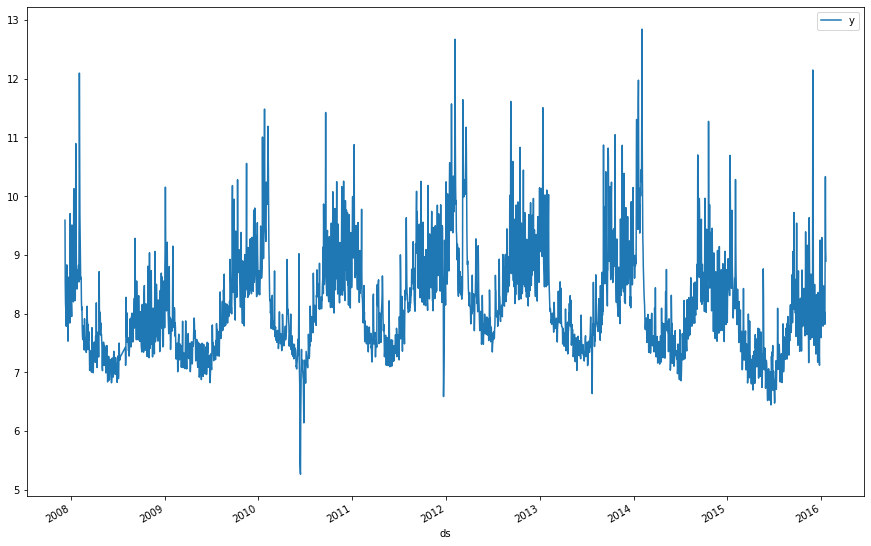

In [18]:
dft = pd.DataFrame(res.json()["data"], columns=res.json()["header"])
dft["ds"] = pd.to_datetime(dft['ds'])
dft["y"] = dft['y'].astype(float)
dft.plot("ds", "y", figsize=[15,10])

## No trained model deployed

So start with training on the relevant time series data.

In [19]:
tr = requests.post(base_url + "train", json = res.json())
print(tr)
print(tr.json())
model_id = tr.json()["model_id"]

<Response [200]>
{'size': [2905, 2], 'training_time': 12.193, 'model_id': '6702dd911e31c013c48dab4cf15baac1e3d2460e'}


### Keep track of the model_id for the relevant training

So using this model is a it more complicated than the original example. In this case, we have made the training very naive.

Tradeoffs are: efficiency of 1-time training and reusing the model (as show here) or complexity of API use.

## Cross-Validate our new model

In [20]:
print(model_id)
xv = requests.get(base_url + f"validation/{model_id}", timeout=120)
print(xv)
print(xv.json())

6702dd911e31c013c48dab4cf15baac1e3d2460e
<Response [200]>
{'data': {'horizon': {'0': 3196800000, '1': 3283200000, '2': 3369600000, '3': 3456000000, '4': 3542400000, '5': 3628800000, '6': 3715200000, '7': 3801600000, '8': 3888000000, '9': 3974400000, '10': 4060800000, '11': 4147200000, '12': 4233600000, '13': 4320000000, '14': 4406400000, '15': 4492800000, '16': 4579200000, '17': 4665600000, '18': 4752000000, '19': 4838400000, '20': 4924800000, '21': 5011200000, '22': 5097600000, '23': 5184000000, '24': 5270400000, '25': 5356800000, '26': 5443200000, '27': 5529600000, '28': 5616000000, '29': 5702400000, '30': 5788800000, '31': 5875200000, '32': 5961600000, '33': 6048000000, '34': 6134400000, '35': 6220800000, '36': 6307200000, '37': 6393600000, '38': 6480000000, '39': 6566400000, '40': 6652800000, '41': 6739200000, '42': 6825600000, '43': 6912000000, '44': 6998400000, '45': 7084800000, '46': 7171200000, '47': 7257600000, '48': 7344000000, '49': 7430400000, '50': 7516800000, '51': 760320

## Use our new model to predict forward 180 periods

In [21]:
print(model_id)
pr = requests.post(base_url + "predict", json = {"size": 180, "data":[], "model_id": model_id})

6702dd911e31c013c48dab4cf15baac1e3d2460e


['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat']


<AxesSubplot:xlabel='ds'>

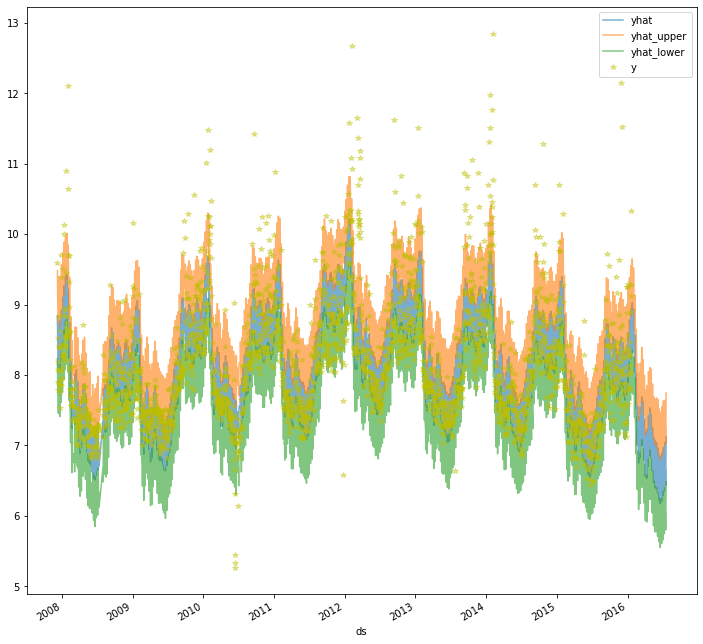

In [22]:
print(pr.json()["header"])
dfr = pd.DataFrame(pr.json()["data"], columns=pr.json()["header"])
dfr["ds"] = pd.to_datetime(dfr['ds'])
ax = dfr.plot("ds",["yhat", "yhat_upper", "yhat_lower"], figsize=[12,12], alpha=0.6)
dft.plot("ds", "y", ax=ax, style="y*", alpha=0.4)

## Model Persistence Makes Deployments More Complex

In [23]:
! cat ../Deployment.yaml

apiVersion: apps/v1
kind: Deployment
metadata:
  name: ts-model-service
  labels:
    app: ts-model-service
    tier: backend
    version: v1
spec:
  selector:
    matchLabels:
      app: ts-model-service
  replicas: 2
  template:
    metadata:
      labels:
        app: ts-model-service
    spec:
      containers:
      - name: ts-model-service
        image: localhost:32000/ts-model-service
        ports:
        - containerPort: 8085
        env:
          - name: APP_NAME
            value: TS-MODEL
        volumeMounts:
          - mountPath: "/cache/model-storage"
            name: model-storage
      volumes:
      - name: model-storage
        persistentVolumeClaim:
          claimName: model-storage-claim


In [24]:
!kubectl get pods

NAME                                      READY   STATUS    RESTARTS      AGE
nfs-client-provisioner-5657b95688-jcttv   1/1     Running   4 (27h ago)   11d
book-service-696f4bfbcc-j462p             1/1     Running   1 (28h ago)   6d19h
bar-app-6fff946c85-6qfnq                  1/1     Running   1 (28h ago)   11d
foo-app-86bdcc9f98-t4c4l                  1/1     Running   1 (28h ago)   11d
book-service-696f4bfbcc-f6tqb             1/1     Running   1 (28h ago)   6d19h
foo-app-86bdcc9f98-24jg9                  1/1     Running   1 (28h ago)   11d
bar-app-6fff946c85-qjtxs                  1/1     Running   1 (28h ago)   11d
earnings-model-service-64d9bfcf7-qfnwc    1/1     Running   0             22h
earnings-model-service-64d9bfcf7-zvknr    1/1     Running   0             22h
ts-model-service-dd46799bf-wqrnw          1/1     Running   0             10m
ts-model-service-dd46799bf-ttvhb          1/1     Running   0             9m57s


In [25]:
!kubectl get pvc

NAME                  STATUS   VOLUME                                     CAPACITY   ACCESS MODES   STORAGECLASS          AGE
test-claim            Bound    pvc-456464a4-c78c-4434-87d3-71614817e27c   1Mi        RWX            managed-nfs-storage   18d
model-storage-claim   Bound    pvc-d14725db-e16b-480f-9123-d664cca56659   10Mi       RWX            managed-nfs-storage   23h


In [26]:
!ssh ubuntu@192.168.127.11 ls -lh /mnt/disk/vol1/k8s_nfs/default-model-storage-claim-pvc-d14725db-e16b-480f-9123-d664cca56659/

total 241M
-rw-r--r-- 1 nobody nogroup 41M Jun 13 22:12 54e66fd46ea88d54e67a2172dba4757193232adf.pkl
-rw-r--r-- 1 nobody nogroup 41M Jun 14 21:07 6148511ecb61b3ceab5b759c5818e43ec5c42dcd.pkl
-rw-r--r-- 1 nobody nogroup 41M Jun 14 21:49 6702dd911e31c013c48dab4cf15baac1e3d2460e.pkl
-rw-r--r-- 1 nobody nogroup 41M Jun 14 20:47 7e4dc16ef2e110a82301db3ce8682d4d28b1e648.pkl
-rw-r--r-- 1 nobody nogroup 41M Jun 14 20:42 a1405046acc9e4e055caf8c3df36c4644b9d2db1.pkl
-rw-r--r-- 1 nobody nogroup 41M Jun 14 20:55 ec83c714355d3c73236a9db99ec705bdb45fabf1.pkl
